In [13]:
import io
from urllib.request import urlopen, Request
from urllib.parse import urlparse
from PIL import Image
from PIL.Image import Image as PilImage
import os
import matplotlib.pyplot as plt


In [119]:
def url_to_pil(url:str) -> PilImage:
    headers = { 'User-Agent': 'Mozilla/6.0'}
    data = urlopen(Request(url, headers=headers)).read()
    bts = io.BytesIO(data)
    im = Image.open(bts).convert('RGB')
    im.filename = urlparse(url).path
    return im

In [40]:
import textwrap

def display_images(
    images: [PilImage], 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print("Showing {} images of {}:".format(max_images, len(images)))
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
#             title=image.filename
#             if title.endswith("/"): title = title[0:-1]
#             title=os.path.basename(title)
            if i==0:
                title= "Searched image:"
            else:
                title = "Result {}".format(i)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 


In [4]:
from annoy import AnnoyIndex
import pickle
from sklearn.model_selection import train_test_split
from collections import defaultdict
import numpy as np 
from tqdm import tqdm
import random


In [5]:
DATA_PATH = 'data.pickle'
IMAGE_EMBEDDINGS_PATH = 'image_embeddings.pickle'



In [6]:
from knn_evaluate import inference, read_pickle, write_pickle

In [7]:
def load_indices():
	data = read_pickle(DATA_PATH)
	image_embeddings = read_pickle(IMAGE_EMBEDDINGS_PATH)
	embedding_size = len(image_embeddings[0])
	t = AnnoyIndex(embedding_size, 'euclidean')  # Length of item vector that will be indexed
	t.load('image_embeddings_annoy_indices.ann') # super fast, will just mmap the file
	return t


In [8]:
t = load_indices()
data = read_pickle(DATA_PATH)

In [46]:
def random_inference(t, data):
    i =  random.sample(range(len(data)), 1)[0]
    results = t.get_nns_by_item(i, 5)
    if results[0]!=i:
        results = [i]+ [results]
    result_image_paths = [data[result] for result in results]
    images = [Image.open(image) for image in result_image_paths]
    display_images(images)    

In [79]:
import zmq
def init_zmq_client():
    port = "5558"
    ip = "192.168.6.21"
    context = zmq.Context()
    print ("Connecting to server...")
    socket = context.socket(zmq.REQ)
    socket.connect ("tcp://%s:%s" % (ip, port))
    return socket

In [77]:
def fetch_embedding_from_zmq_client(socket, img_url):
    string = img_url.encode("utf_8")
    socket.send(string)
    msg = socket.recv()
    s2_soft = np.frombuffer(msg, dtype = np.float32)
    return s2_soft


In [117]:
zmq_socket = init_zmq_client()

Connecting to server...


In [120]:
def inference_from_url(t, data, zmq_socket, url):
    try:
        image_embedding = fetch_embedding_from_zmq_client(zmq_socket, url)
        print(image_embedding.shape)
        if image_embedding.shape[0] == 1:
            print("Error from embedding server")
            return
        print("image embedding recieved")
        
        img_pil = url_to_pil(url)
        results = t.get_nns_by_vector(image_embedding, 5, search_k=-1, include_distances=False)
        print("Nearest nbs found")
        result_image_paths = [data[result] for result in results]
        images = [Image.open(image) for image in result_image_paths]
        images = [img_pil] + images
        print("Displaying images")
        display_images(images)    
        
    except Exception as e:
        print("Error")
        print(e)


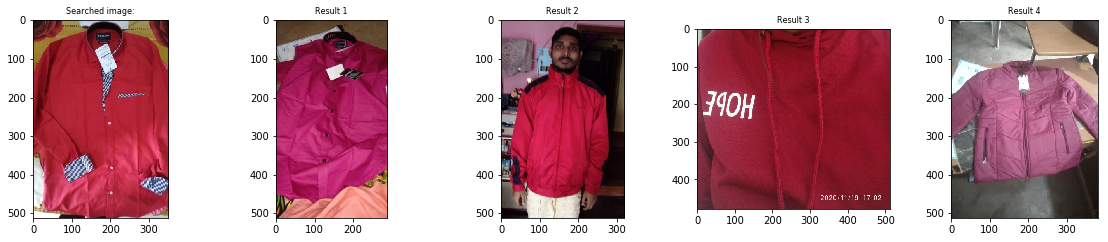

In [205]:
random_inference(t, data)

In [124]:
img_url = 'https://i.pinimg.com/originals/27/03/cc/2703cc2cbd4a1cbf7e3ee4cbd5dd14b5.jpg'

(2048,)
image embedding recieved
Nearest nbs found
Displaying images


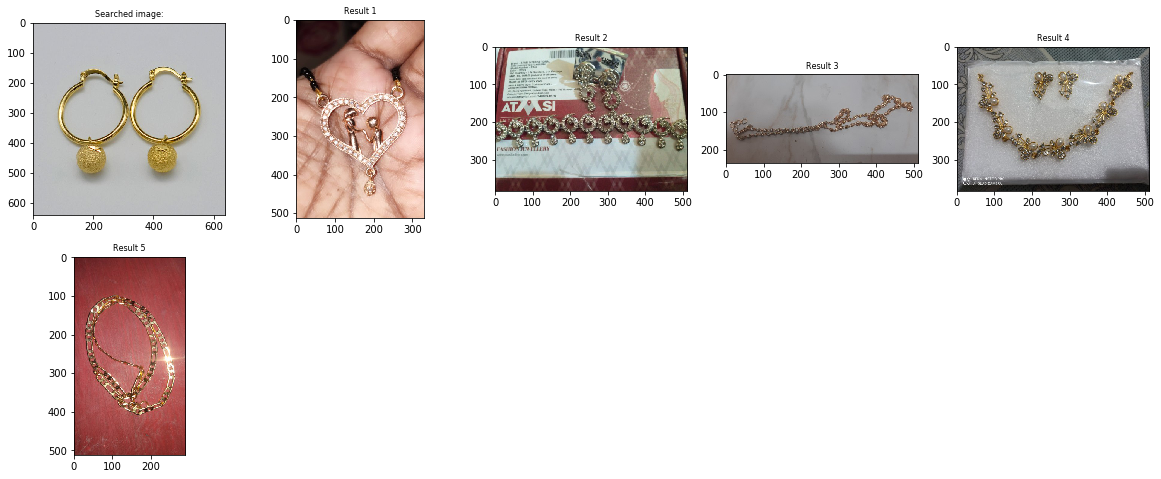

In [125]:
inference_from_url(t, data, zmq_socket, img_url)